# Marshall Smith Final Project

I will be analyzing the homicide rate in certain states and see how they are affected by the median household income within the state. The year that we will assess is 2018.

I will do this through A/B testing because it allows us to make comparisons between two distributions

In [149]:
# Run this cell to set up the notebook, but please don't change it.

# These lines import the Numpy and Datascience modules.
import numpy as np
from datascience import *
from datascience import Table

from scipy.stats import linregress

# These lines do some fancy plotting magic.
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import warnings
warnings.simplefilter('ignore', FutureWarning)

In [10]:
#First we must load the data into the table

homicide_rates = Table.read_table('homicide_rates.csv').select('State', 'Median income', 'Homicide Rate (per 100,000)')
homicide_rates.set_format("Median income", NumberFormatter)

State,Median income,"Homicide Rate (per 100,000)"
United States,"63,179",nan
Alabama,"49,936",15.9
Alaska,"68,734",6.4
Arizona,"62,283",8.1
Arkansas,"49,781",11.7
California,"70,489",6.4
Colorado,"73,034",6.3
Connecticut,"72,812",4.8
Delaware,"65,012",11.3
D.C.,"85,750",nan


This table shows every state's median income along with their homicide rate per 100,000.  This table will be useful in determining how statistically significant the median income is when it comes to homicide rates.

# Question 1

My first question that I am aiming to answer is this: How does the median household income affect the homicide rate within a state?

This is an interesting question because typically higher crime areas have a higher poverty rate.  This is because people who need something will typically go to more extremes in order to get it.  For example, it may be safer to walk through Beverly Hills with a gold chain on as opposed to an extremely low income area.  

Null Hypothesis: There is no relationship between median household income and homicide rate

Alternative Hypothesis: There is a relationship between median household income and homicide rate


These are my hypothesis because typically higher poverty areas have a higher crime rate

First, I will need to clean my data so that all states that do not have information for all required columns will be deleted. 

For example, D.C. does not have a homicide rate so it will be deleted

In [12]:
# Filter out rows where 'Median income' or 'Homicide Rate (per 100,000)' is not a number
filtered_homicide_rates = homicide_rates.where(
    (np.isnan(homicide_rates['Median income']) == False) &
    (np.isnan(homicide_rates['Homicide Rate (per 100,000)']) == False)
)

# Print the filtered table
print(filtered_homicide_rates)


State       | Median income | Homicide Rate (per 100,000)
Alabama     | 49,936        | 15.9
Alaska      | 68,734        | 6.4
Arizona     | 62,283        | 8.1
Arkansas    | 49,781        | 11.7
California  | 70,489        | 6.4
Colorado    | 73,034        | 6.3
Connecticut | 72,812        | 4.8
Delaware    | 65,012        | 11.3
Florida     | 54,644        | 7.4
Georgia     | 55,821        | 11.4
... (37 rows omitted)


In [13]:
filtered_homicide_rates.show()

State,Median income,"Homicide Rate (per 100,000)"
Alabama,"49,936",15.9
Alaska,"68,734",6.4
Arizona,"62,283",8.1
Arkansas,"49,781",11.7
California,"70,489",6.4
Colorado,"73,034",6.3
Connecticut,"72,812",4.8
Delaware,"65,012",11.3
Florida,"54,644",7.4
Georgia,"55,821",11.4


Now that I have cleaned the data I will plot a histogram where Median Income is on the y-axis and the homicide rate as the x-axis. 

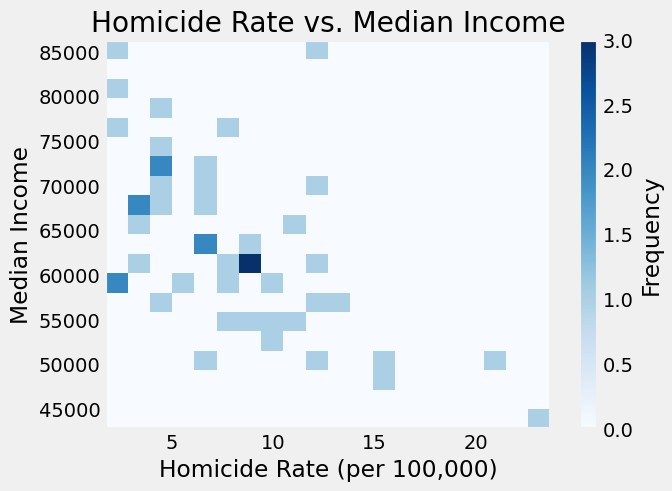

In [16]:
homicide_rates = filtered_homicide_rates.column('Homicide Rate (per 100,000)')
median_income = filtered_homicide_rates.column('Median income')

plt.hist2d(homicide_rates, median_income, bins=20, cmap='Blues')
plt.colorbar(label='Frequency')
plt.xlabel('Homicide Rate (per 100,000)')
plt.ylabel('Median Income')
plt.title('Homicide Rate vs. Median Income')
plt.show()


This histogram gives us a a good look at how the median income affects the homicide rate.  The darker bins signify more data points within that bin.  

There looks to be no correlation between the two just at first look at the histogram

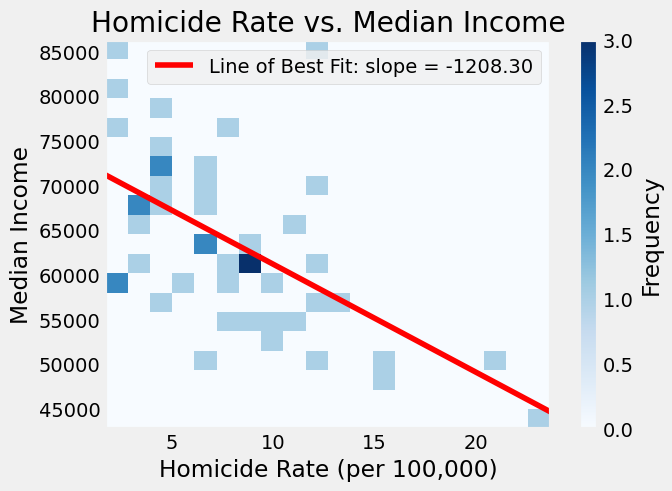

The slope of the line of best fit is: -1208.30


In [150]:
#Histogram with line of best fit

# Extract data
homicide_rates = filtered_homicide_rates.column('Homicide Rate (per 100,000)')
median_income = filtered_homicide_rates.column('Median income')

# Perform linear regression
slope, intercept, _, _, _ = linregress(homicide_rates, median_income)

# Plot the 2D histogram
plt.hist2d(homicide_rates, median_income, bins=20, cmap='Blues')
plt.colorbar(label='Frequency')
plt.xlabel('Homicide Rate (per 100,000)')
plt.ylabel('Median Income')
plt.title('Homicide Rate vs. Median Income')

# Add the line of best fit
x_values = np.linspace(min(homicide_rates), max(homicide_rates), 100)
plt.plot(x_values, slope * x_values + intercept, color='red', label=f'Line of Best Fit: slope = {slope:.2f}')

# Show legend
plt.legend()

# Show the plot
plt.show()

# Print the slope of the line of best fit
print(f"The slope of the line of best fit is: {slope:.2f}")



In [81]:
rate_means = filtered_homicide_rates.group('Median income', np.mean)
rate_means = rate_means.select(['Median income', 'Homicide Rate (per 100,000) mean']).relabeled('Homicide Rate (per 100,000) mean', 'Average Homicide Rate')

rate_means

Median income,Average Homicide Rate
42781,23.7
48283,15.3
49781,11.7
49936,15.9
49973,21.3
50573,6.9
53369,9.7
54434,8.9
54555,9.6
54644,7.4


The code "rate_means" provides insights into how the average homicide rate varies across different income levels, which can be useful for analyzing potential correlations or patterns between income and homicide rates.

I made the condition that seperates the two groups to be greater than or less than $50,000

If the median income is less than $50,000, then it would be grouped as false.  If the median income is greater than $50,000, then it would be grouped as true.  We are observing the difference between the two groups

In [125]:
group_true = rate_means.where('Median income', are.above(50000))
group_false = rate_means.where('Median income', are.below_or_equal_to(50000))


if group_true.num_rows > 0 and group_false.num_rows > 0:
    observed_difference = group_true.column('Average Homicide Rate').item(0) - group_false.column('Average Homicide Rate').item(0)
else:
    observed_difference = 0

observed_difference


-16.799999999999997

This negative value suggests that, on average, areas with higher median incomes tend to have lower homicide rates compared to areas with lower median incomes.

In [132]:
def find_test_stat(table, labels_col, values_col):
    group_means = table.group(labels_col, np.mean)
    values = group_means.column(f'{values_col} mean')
    return values.item(1) - values.item(0)


test_statistic = find_test_stat(filtered_homicide_rates, "Median income", "Homicide Rate (per 100,000)")
print(test_statistic)




-8.399999999999999


This value suggests the same thing as the previous value

In [131]:
def simulate_and_test_statistic(table, labels_col, values_col):
    shuffled_table = table.sample(with_replacement=False).column(labels_col)
    shuffled_table = table.select(values_col).with_column('Shuffled', shuffled_table)
    return find_test_stat(shuffled_table, 'Shuffled', values_col)

simulate_and_test_statistic(filtered_homicide_rates, "Median income", "Homicide Rate (per 100,000)")




5.3999999999999995

I will now simulate 5000 trials of this A/B test and store the statistics in an array called "differences"

In [94]:
num_trials = 5000

differences = make_array()

for _ in range(num_trials):
    test_statistic = simulate_and_test_statistic(filtered_homicide_rates, "Median income", "Homicide Rate (per 100,000)")
    differences = np.append(differences, test_statistic)

differences

array([  3.2,  -5.1,  10.5, ...,   1.5,  13. ,   6.4])

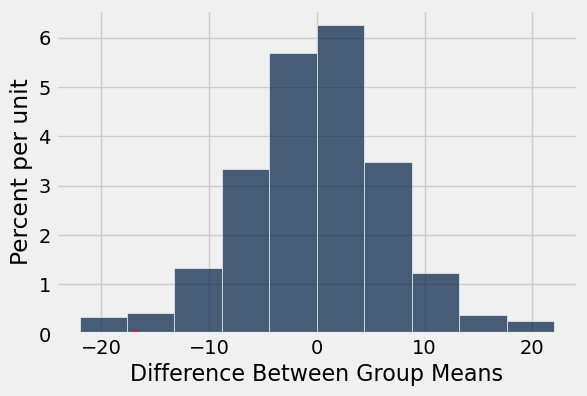

In [96]:
Table().with_column('Difference Between Group Means', differences).hist()
plt.scatter(observed_difference, 0, color='red', s=30, zorder=2);

I will now find the p-value for my test and assign it to 'emperical_p'

In [98]:
empirical_P = np.count_nonzero(differences >= observed_difference) / num_trials
empirical_P

0.9812

Using a 5% P-value cutoff, we would fail to reject the null hypothesis.  This means that there is no direct correlation to poverty level and homicide rates.  They all just happen by chance or other factors affect it more.

# Question 2

What State has the highest homicide rate?
What is its Median income?

In [105]:
highest_homicide_rate_state = filtered_homicide_rates.sort('Homicide Rate (per 100,000)', descending=True).column('State').item(0)
print("State with the highest homicide rate:", highest_homicide_rate_state)

highest_homicide_rate_state = filtered_homicide_rates.sort('Homicide Rate (per 100,000)', descending=True).column('State').item(0)

state_data = filtered_homicide_rates.where('State', highest_homicide_rate_state)

median_income_highest_homicide_rate_state = state_data.column('Median income').item(0)
print("Median income in", highest_homicide_rate_state,':', median_income_highest_homicide_rate_state)


State with the highest homicide rate: Mississippi
Median income in Mississippi : 42781


# Question 3

What state has the highest median income rate and what is that state's homicide rate?

In [106]:
highest_median_income_state = filtered_homicide_rates.sort('Median income', descending=True).column('State').item(0)

state_data = filtered_homicide_rates.where('State', highest_median_income_state)

homicide_rate_highest_median_income_state = state_data.column('Homicide Rate (per 100,000)').item(0)

print("State with the highest median income:", highest_median_income_state)
print("Homicide rate in", highest_median_income_state,':', homicide_rate_highest_median_income_state)


State with the highest median income: Massachusetts
Homicide rate in Massachusetts : 2.3


# Question 4

How is life expectancy at birth affected by homicide rate?

This question is interesting because we could assume that the homicide rate affects life expectancy.  If there is a higher chance of homicide, we could assume that the life expectancy would be lower.  For example, we hear about gang members lives being cut short due to violence and high homicide rates.  I am curious to see if there is a correlation

Null Hypothesis: There is not significant relationship between life expectancy at birth and homicide rate

Alternative Hypothesis: There is a significant relationship between life expectancy at birth and homicide rate

In [109]:
#First we must load data into the table

life_expectancy_rates = Table.read_table('homicide_rates.csv').select('State', 'Homicide Rate (per 100,000)', 'Life Expectancy (At Birth)')
life_expectancy_rates.set_format('Homicide Rate (per 100,000)', NumberFormatter)

State,"Homicide Rate (per 100,000)",Life Expectancy (At Birth)
United States,nan,nan
Alabama,15.90,73.2
Alaska,6.40,76.6
Arizona,8.10,76.3
Arkansas,11.70,73.8
California,6.40,79
Colorado,6.30,78.3
Connecticut,4.80,78.4
Delaware,11.30,76.7
D.C.,nan,nan


Now we must clean the code to eliminate any state that does not contain a value for both columns

In [110]:
# Filter out rows where 'Life Expectancy' or 'Homicide Rate (per 100,000)' is not a number
filtered_life_expectancy = life_expectancy_rates.where(
    (np.isnan(life_expectancy_rates['Life Expectancy (At Birth)']) == False) &
    (np.isnan(life_expectancy_rates['Homicide Rate (per 100,000)']) == False)
)

# Print the filtered table
print(filtered_life_expectancy)

State       | Homicide Rate (per 100,000) | Life Expectancy (At Birth)
Alabama     | 15.90                       | 73.2
Alaska      | 6.40                        | 76.6
Arizona     | 8.10                        | 76.3
Arkansas    | 11.70                       | 73.8
California  | 6.40                        | 79
Colorado    | 6.30                        | 78.3
Connecticut | 4.80                        | 78.4
Delaware    | 11.30                       | 76.7
Florida     | 7.40                        | 77.5
Georgia     | 11.40                       | 75.6
... (37 rows omitted)


In [111]:
filtered_life_expectancy.show()

State,"Homicide Rate (per 100,000)",Life Expectancy (At Birth)
Alabama,15.90,73.2
Alaska,6.40,76.6
Arizona,8.10,76.3
Arkansas,11.70,73.8
California,6.40,79
Colorado,6.30,78.3
Connecticut,4.80,78.4
Delaware,11.30,76.7
Florida,7.40,77.5
Georgia,11.40,75.6


Now that I have cleaned the data I will plot a histogram where Homicide Rate is on the y-axis and life expectancy is the x-axis.

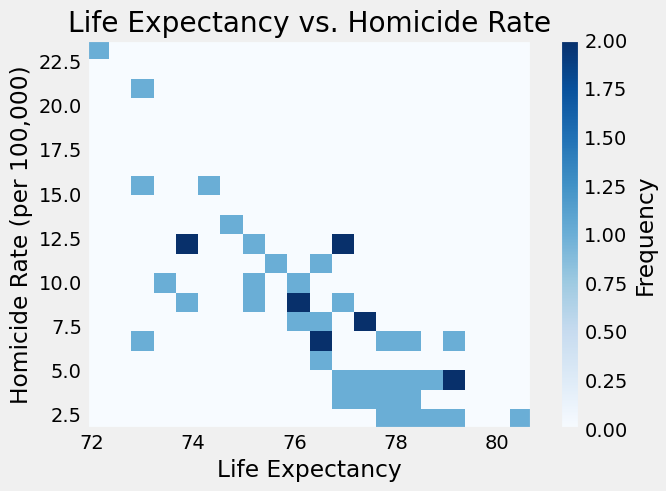

In [112]:
homicide_rates = filtered_life_expectancy.column('Homicide Rate (per 100,000)')
life_expectancy = filtered_life_expectancy.column('Life Expectancy (At Birth)')

plt.hist2d(life_expectancy, homicide_rates, bins=20, cmap='Blues')
plt.colorbar(label='Frequency')
plt.xlabel('Life Expectancy')
plt.ylabel('Homicide Rate (per 100,000)')
plt.title('Life Expectancy vs. Homicide Rate')
plt.show()


This histogram is showing slight correlation.  Meaning the higher the homicide rate, the lower the life expectancy.

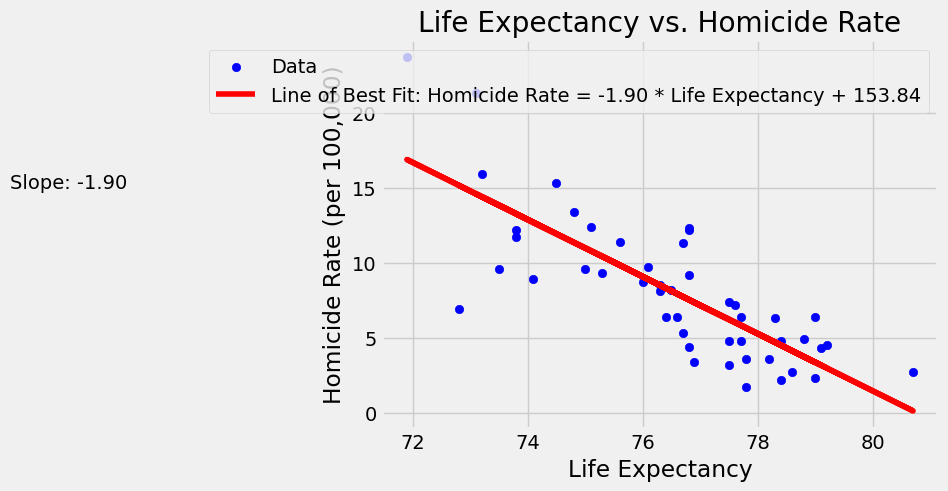

In [147]:
#Plot another histogram with line of best fit



# Extract data
homicide_rates = filtered_life_expectancy.column('Homicide Rate (per 100,000)')
life_expectancy = filtered_life_expectancy.column('Life Expectancy (At Birth)')

# Perform linear regression
slope, intercept, _, _, _ = linregress(life_expectancy, homicide_rates)

# Plot the scatter plot
plt.scatter(life_expectancy, homicide_rates, c='blue', label='Data')

# Plot the line of best fit
plt.plot(life_expectancy, slope * life_expectancy + intercept, c='red', label=f'Line of Best Fit: Homicide Rate = {slope:.2f} * Life Expectancy + {intercept:.2f}')

# Add slope of the line of best fit
plt.text(65, 15, f'Slope: {slope:.2f}', color='black')

# Add labels and title
plt.xlabel('Life Expectancy')
plt.ylabel('Homicide Rate (per 100,000)')
plt.title('Life Expectancy vs. Homicide Rate')

# Add legend
plt.legend()

# Show plot
plt.show()



In [116]:
rate_mean = filtered_life_expectancy.group('Homicide Rate (per 100,000)', np.mean)
rate_mean = rate_mean.select(['Homicide Rate (per 100,000)', 'Life Expectancy (At Birth) mean']).relabeled('Life Expectancy (At Birth) mean', 'Average Life Expectancy')

rate_mean

"Homicide Rate (per 100,000)",Average Life Expectancy
1.7,77.8
2.2,78.4
2.3,79
2.7,79.65
3.2,77.5
3.4,76.9
3.6,78
4.3,79.1
4.4,76.8
4.5,79.2


By grouping the data by homicide rates and calculating the mean life expectancy for each group, this code allows us to understand if there's any observable trend or correlation between higher homicide rates and lower life expectancy, or vice versa. It helps us investigate whether there's an association between these two variables.

This code is comparing the average life expectancy of states with high homicide rates (above 5.0) to those with lower homicide rates (5.0 or below).

In [123]:
true_group = rate_mean.where('Homicide Rate (per 100,000)', are.above(5.0))
false_group = rate_mean.where('Homicide Rate (per 100,000)', are.below_or_equal_to(5.0))


if true_group.num_rows > 0 and false_group.num_rows > 0:
    difference_observed = true_group.column('Average Life Expectancy').item(0) - false_group.column('Average Life Expectancy').item(0)
else:
    difference_observed = 0

difference_observed

-1.0999999999999943

Since the value of difference_observed is -1, it means that, on average, states with a homicide rate above 5.0 have a life expectancy that is 1 year lower than states with a homicide rate of 5.0 or below.

In [135]:
test_stat = find_test_stat(filtered_life_expectancy, "Homicide Rate (per 100,000)", 'Life Expectancy (At Birth)')
print(test_stat)

0.6000000000000085


This value shows an extremely weak correlation that says as homicide rate increases so does life expectancy.  This is a very weak correlation

In [139]:
simulate_and_test_statistic(filtered_life_expectancy, "Homicide Rate (per 100,000)", 'Life Expectancy (At Birth)')

1.5

I will now simulate 5000 trials of this A/B test and store the statistics in an array called "difference"

In [140]:
numb_trials = 5000

difference = make_array()

for _ in range(numb_trials):
    test_stat = simulate_and_test_statistic(filtered_life_expectancy, "Homicide Rate (per 100,000)", 'Life Expectancy (At Birth)')
    difference = np.append(difference, test_stat)

difference

array([ 1.7, -0.3, -3.8, ..., -2.2,  4.9, -4.9])

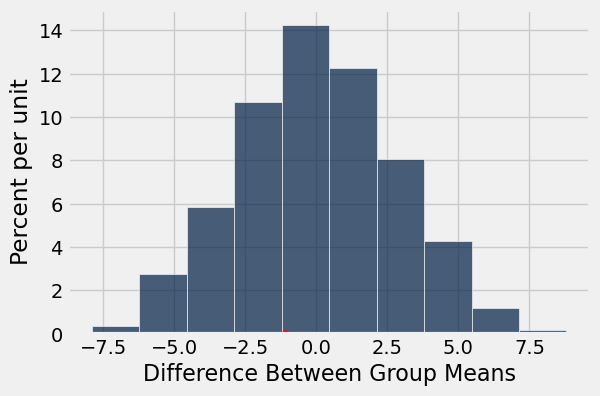

In [141]:
Table().with_column('Difference Between Group Means', difference).hist()
plt.scatter(difference_observed, 0, color='red', s=30, zorder=2);



Now I will find the p-value and assign it to 'p_empirical'

In [142]:
p_empirical = np.count_nonzero(difference >= difference_observed) / num_trials
p_empirical

0.6564

Using a 5% p-value cutoff, we would fail to reject the null hypothesis which means that there is nit a correlation between homicide rates and life expectancy at birth.

A p-value of 0.65 means that in 65% of the simulated trials, the observed difference between group means or a more extreme difference occurred by random chance alone.